In [1]:
# Execute if necessary
# %%capture
# !pip install numpy seaborn matplotlib pandas openml

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, Tuple, Union, List
import openml
import sklearn

# Práctica 4: Overfitting

__Instrucciones__: A continuación hay una lista de funciones que debe implementar o tareas que debe desarrollar. La descripción de cada una de ellas se encuentra en la definición de cada una de las funciones. Cada función está marcada por &#x1F625;,  &#x1F643; o &#x1F921;. Las marcas indican:

- &#x1F625;: Indican una entrega que debe ser hecha dentro de la misma sesión de la asignación. 
- &#x1F643;: Indican una entrega que puede ser hecha hasta la siguiente sesión.
- &#x1F921;: Debe mostrar un avance en la misma sesión, pero la entrega puede ser hecha en la siguiente.

Aquellas entregas parciales que no sean hechas el día de la asignación ya no serán válidas para las entregas totales, sin embargo, las entregas totales seguirán siendo válidas.

En esta sección se incluye un dataset real. El dataset importado se llama LDPA y puede leer su descripción en la siguiente liga

https://www.openml.org/d/1483

In [3]:
# Descarga la metadata del dataset
dataset_info = openml.datasets.get_dataset(1483, download_data=False)

# Obtiene el nombre de la columna a predecir
target = dataset_info.default_target_attribute

(
    features, # Dataframe con las características que se pueden utilizar para predecir
    outputs, # Columna a predecir
    categorical_mask, # Máscara que indica que columnas de todas las características son categoricas
    columns # Lista con el nombre de las características
)= dataset_info.get_data(
    dataset_format="dataframe", target=target
)

categorical_mask = np.array(categorical_mask)
columns = np.array(columns)

In [4]:
print(f"La columna a predecir se llama '{target}'")
print(f"Todas las características son {str(columns)}")
print(f"Las características categóricas son {str(columns[categorical_mask])}")
print(f"Las características numéricas son {str(columns[~categorical_mask])}")

La columna a predecir se llama 'Class'
Todas las características son ['V1' 'V2' 'V3' 'V4' 'V5' 'V6' 'V7']
Las características categóricas son ['V1' 'V2']
Las características numéricas son ['V3' 'V4' 'V5' 'V6' 'V7']


In [5]:
# Impresión de las características
features

,V1,V2,V3,V4,V5,V6,V7
0,1,1,105794.0,105777.0,148933.0,108479.0,109365.0
1,1,4,105795.0,105778.0,155325.0,96952.0,161363.0
2,1,3,105796.0,105779.0,156652.0,101610.0,148870.0
3,1,1,105797.0,105780.0,149736.0,107135.0,102479.0
4,1,2,105798.0,105781.0,155978.0,125455.0,106203.0
...,...,...,...,...,...,...,...
164855,5,2,43687.0,43679.0,106611.0,123166.0,12432.0
164856,5,1,43688.0,43680.0,120821.0,119848.0,87463.0
164857,5,4,43689.0,43681.0,104999.0,110823.0,161536.0
164858,5,2,43690.0,43682.0,102191.0,112520.0,10811.0


In [6]:
outputs

0         3
1         3
2         3
3         3
4         3
         ..
164855    3
164856    3
164857    3
164858    3
164859    3
Name: Class, Length: 164860, dtype: category
Categories (11, object): ['1' < '2' < '3' < '4' ... '8' < '9' < '10' < '11']

A continuación se realiza la partición de __train__ y __test__. __No debe utilizar la partición de test por ningún motivo__.

In [7]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    features, 
    outputs, 
    test_size=0.5, 
    random_state=11
)

In [8]:
#X_train.index.values

## Asignación 1 &#x1F921;

Utilizando las técnicas vistas en clase, realicé su mejor esfuerzo para obtener el mejor modelo lineal posible utilizando __únicamente el conjunto de entrenamiento__ (X_train y y_train). Puede utilizar bibliotecas, pero únicamente las técnicas vistas en clase y debe ir generando métricas o visualizaciones que respalden su toma de decisiones. Debe tener e imprimir una estimación de $E_{out}$ utilizando su conjunto de entrenamiento. La métrica utilizada será la entropía cruzada.

### Preprocesamiento

In [9]:
def scale_data(data, cols):
    for c in cols:
        column = data[c]
        sc_column = scale_column(column)
        data[c] = sc_column
    return data

In [10]:
def scale_column(x):
    return (x - x.mean()) / x.std()

In [11]:
def ohe(df, columns):
    for col in columns:
        #print(col)
        col_encoded = pd.get_dummies(pd.Series(df[col]))
        #print(col_encoded.head(3))
        df[['{}_'.format(col) + str(c) for c in list(col_encoded.columns.values)]] = col_encoded
        df = df.drop(columns = col)
        
    return df

In [12]:
def check_nans(df):
    for c in list(df.columns.values):
        print(c + ' NaNs -> ' + str(df[c].isnull().sum()))

In [13]:
def plot_hist(column):
    skewness = calc_skewness(column)
    __fig__, __axs__ = plt.subplots(ncols=1, figsize=(15, 5))
    __fig__.subplots_adjust(hspace=0.1, wspace=0.3)
    
    __axs__.set(title="Column (mean = {}, std = {}, skewness = {})".format(round(column.mean(), 2), round(column.std(), 2), round(skewness, 2)))
    _ = sns.histplot(x=column, ax=__axs__)
    _.axvline(x=column.mean(),
                color='blue',
                ls='--', 
                lw=2.5)

In [14]:
def calc_skewness(x):
    return (((x - x.mean()) / (x.var() ** (1/2))) ** 3).mean()

In [15]:
def minmax_scale_column(x):
    return (x - x.min()) / (x.max() - x.min())

In [16]:
#X_train['V1'] = pd.to_numeric(X_train['V1'])
#X_train['V2'] = pd.to_numeric(X_train['V2'])
#X_train

In [17]:
all_train = pd.concat((X_train, y_train), axis = 1)
all_train

,V1,V2,V3,V4,V5,V6,V7,Class
82677,3,3,158321.0,158297.0,72476.0,106489.0,146328.0,3
2843,1,1,108637.0,108619.0,135179.0,75851.0,79479.0,10
50670,2,2,98841.0,98825.0,76316.0,137080.0,101775.0,4
128441,5,4,7274.0,7273.0,97161.0,128160.0,137973.0,2
10592,1,2,116386.0,116368.0,70382.0,140689.0,119402.0,4
...,...,...,...,...,...,...,...,...
102327,4,2,56803.0,56792.0,146134.0,114564.0,47575.0,3
97617,4,2,52093.0,52085.0,54989.0,81198.0,26584.0,11
21584,1,1,127378.0,127358.0,44795.0,105412.0,49255.0,3
36543,2,2,84714.0,84700.0,59207.0,33106.0,114460.0,3


In [18]:
all_train[['V5', 'V6', 'Class']]

,V5,V6,Class
82677,72476.0,106489.0,3
2843,135179.0,75851.0,10
50670,76316.0,137080.0,4
128441,97161.0,128160.0,2
10592,70382.0,140689.0,4
...,...,...,...
102327,146134.0,114564.0,3
97617,54989.0,81198.0,11
21584,44795.0,105412.0,3
36543,59207.0,33106.0,3


In [19]:
#sns.pairplot(all_train, hue = 'Class', diag_kind='kde')

In [21]:
import copy

In [22]:
all_train_aux = copy.deepcopy(all_train)
all_train_aux

,V1,V2,V3,V4,V5,V6,V7,Class
82677,3,3,158321.0,158297.0,72476.0,106489.0,146328.0,3
2843,1,1,108637.0,108619.0,135179.0,75851.0,79479.0,10
50670,2,2,98841.0,98825.0,76316.0,137080.0,101775.0,4
128441,5,4,7274.0,7273.0,97161.0,128160.0,137973.0,2
10592,1,2,116386.0,116368.0,70382.0,140689.0,119402.0,4
...,...,...,...,...,...,...,...,...
102327,4,2,56803.0,56792.0,146134.0,114564.0,47575.0,3
97617,4,2,52093.0,52085.0,54989.0,81198.0,26584.0,11
21584,1,1,127378.0,127358.0,44795.0,105412.0,49255.0,3
36543,2,2,84714.0,84700.0,59207.0,33106.0,114460.0,3


In [23]:
all_train_aux = ohe(all_train_aux, ['Class'])

In [25]:
all_train_aux

,V1,V2,V3,V4,V5,V6,V7,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11
82677,3,3,158321.0,158297.0,72476.0,106489.0,146328.0,0,0,1,0,0,0,0,0,0,0,0
2843,1,1,108637.0,108619.0,135179.0,75851.0,79479.0,0,0,0,0,0,0,0,0,0,1,0
50670,2,2,98841.0,98825.0,76316.0,137080.0,101775.0,0,0,0,1,0,0,0,0,0,0,0
128441,5,4,7274.0,7273.0,97161.0,128160.0,137973.0,0,1,0,0,0,0,0,0,0,0,0
10592,1,2,116386.0,116368.0,70382.0,140689.0,119402.0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102327,4,2,56803.0,56792.0,146134.0,114564.0,47575.0,0,0,1,0,0,0,0,0,0,0,0
97617,4,2,52093.0,52085.0,54989.0,81198.0,26584.0,0,0,0,0,0,0,0,0,0,0,1
21584,1,1,127378.0,127358.0,44795.0,105412.0,49255.0,0,0,1,0,0,0,0,0,0,0,0
36543,2,2,84714.0,84700.0,59207.0,33106.0,114460.0,0,0,1,0,0,0,0,0,0,0,0


In [ ]:
#sns.pairplot(all_train_aux, diag_kind='kde')

In [24]:
corr = all_train_aux.corr()
corr.style.background_gradient(cmap = 'YlOrRd')

,V3,V4,V5,V6,V7,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10,Class_11
V3,1.000000,1.000000,-0.090484,-0.022801,0.026448,-0.018094,0.001769,-0.061878,0.035105,-0.006303,0.030381,0.013241,0.003138,0.017465,-0.011038,-0.000651
V4,1.000000,1.000000,-0.090482,-0.022802,0.026448,-0.018094,0.001769,-0.061877,0.035105,-0.006303,0.030381,0.013241,0.003138,0.017465,-0.011037,-0.000651
V5,-0.090484,-0.090482,1.000000,-0.366917,0.026174,0.099744,0.109595,-0.103199,0.027199,-0.176351,-0.179033,0.019103,-0.012052,0.260856,-0.015552,-0.022800
V6,-0.022801,-0.022802,-0.366917,1.000000,0.013580,-0.110304,0.016236,0.036140,0.135998,0.124238,-0.056632,-0.136612,0.010069,-0.196084,0.059371,0.025480
V7,0.026448,0.026448,0.026174,0.013580,1.000000,0.020524,-0.015457,0.123188,-0.165598,-0.008858,-0.125413,0.156985,0.012260,0.028956,-0.047956,-0.000588
Class_1,-0.018094,-0.018094,0.099744,-0.110304,0.020524,1.000000,-0.017615,-0.067674,-0.095359,-0.026636,-0.024859,-0.060510,-0.013899,-0.037707,-0.048426,-0.012623
Class_2,0.001769,0.001769,0.109595,0.016236,-0.015457,-0.017615,1.000000,-0.064448,-0.090814,-0.025367,-0.023675,-0.057626,-0.013236,-0.035910,-0.046118,-0.012021
Class_3,-0.061878,-0.061877,-0.103199,0.036140,0.123188,-0.067674,-0.064448,1.000000,-0.348890,-0.097453,-0.090953,-0.221388,-0.050852,-0.137958,-0.177177,-0.046183
Class_4,0.035105,0.035105,0.027199,0.135998,-0.165598,-0.095359,-0.090814,-0.348890,1.000000,-0.137322,-0.128162,-0.311959,-0.071655,-0.194397,-0.249661,-0.065076
Class_5,-0.006303,-0.006303,-0.176351,0.124238,-0.008858,-0.026636,-0.025367,-0.097453,-0.137322,1.000000,-0.035799,-0.087138,-0.020015,-0.054300,-0.069736,-0.018177


### Para el conjunto de entrenamiento

In [26]:
X_train_pp = copy.deepcopy(X_train)

In [27]:
X_train_pp = ohe(X_train, ['V1', 'V2'])

In [28]:
X_train_pp

,V3,V4,V5,V6,V7,V1_1,V1_2,V1_3,V1_4,V1_5,V2_1,V2_2,V2_3,V2_4
82677,158321.0,158297.0,72476.0,106489.0,146328.0,0,0,1,0,0,0,0,1,0
2843,108637.0,108619.0,135179.0,75851.0,79479.0,1,0,0,0,0,1,0,0,0
50670,98841.0,98825.0,76316.0,137080.0,101775.0,0,1,0,0,0,0,1,0,0
128441,7274.0,7273.0,97161.0,128160.0,137973.0,0,0,0,0,1,0,0,0,1
10592,116386.0,116368.0,70382.0,140689.0,119402.0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102327,56803.0,56792.0,146134.0,114564.0,47575.0,0,0,0,1,0,0,1,0,0
97617,52093.0,52085.0,54989.0,81198.0,26584.0,0,0,0,1,0,0,1,0,0
21584,127378.0,127358.0,44795.0,105412.0,49255.0,1,0,0,0,0,1,0,0,0
36543,84714.0,84700.0,59207.0,33106.0,114460.0,0,1,0,0,0,0,1,0,0


In [29]:
check_nans(X_train_pp)

V3 NaNs -> 0
V4 NaNs -> 0
V5 NaNs -> 0
V6 NaNs -> 0
V7 NaNs -> 0
V1_1 NaNs -> 0
V1_2 NaNs -> 0
V1_3 NaNs -> 0
V1_4 NaNs -> 0
V1_5 NaNs -> 0
V2_1 NaNs -> 0
V2_2 NaNs -> 0
V2_3 NaNs -> 0
V2_4 NaNs -> 0


In [30]:
y_train

82677      3
2843      10
50670      4
128441     2
10592      4
          ..
102327     3
97617     11
21584      3
36543      3
141209     4
Name: Class, Length: 82430, dtype: category
Categories (11, object): ['1' < '2' < '3' < '4' ... '8' < '9' < '10' < '11']

In [ ]:
#plot_hist(X_train_pp.V3)

In [ ]:
#plot_hist(X_train_pp.V4)

In [ ]:
#plot_hist(X_train_pp.V5)

In [ ]:
#plot_hist(X_train_pp.V6)

In [31]:
X_train_pp = scale_data(X_train_pp, ['V3', 'V4', 'V5', 'V6'])

In [32]:
X_train_pp

,V3,V4,V5,V6,V7,V1_1,V1_2,V1_3,V1_4,V1_5,V2_1,V2_2,V2_3,V2_4
82677,1.594401,1.594403,-0.197887,0.522237,146328.0,0,0,1,0,0,0,0,1,0
2843,0.549977,0.549953,1.128656,-0.126258,79479.0,1,0,0,0,0,1,0,0,0
50670,0.344051,0.344040,-0.116648,1.169737,101775.0,0,1,0,0,0,0,1,0,0
128441,-1.580811,-1.580786,0.324348,0.980933,137973.0,0,0,0,0,1,0,0,0,1
10592,0.712871,0.712871,-0.242187,1.246126,119402.0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102327,-0.539644,-0.539679,1.360420,0.693155,47575.0,0,0,0,1,0,0,1,0,0
97617,-0.638655,-0.638641,-0.567841,-0.013081,26584.0,0,0,0,1,0,0,1,0,0
21584,0.943938,0.943929,-0.783505,0.499441,49255.0,1,0,0,0,0,1,0,0,0
36543,0.047083,0.047070,-0.478605,-1.031014,114460.0,0,1,0,0,0,0,1,0,0


In [33]:
X_test_pp = copy.deepcopy(X_test)

In [34]:
X_test_pp = ohe(X_test, ['V1', 'V2'])

In [35]:
X_test_pp = scale_data(X_test_pp, ['V3', 'V4', 'V5', 'V6'])

In [36]:
X_test_pp

,V3,V4,V5,V6,V7,V1_1,V1_2,V1_3,V1_4,V1_5,V2_1,V2_2,V2_3,V2_4
9783,0.697143,0.697141,0.176290,-1.352314,121817.0,1,0,0,0,0,0,0,0,1
85013,1.643977,1.643965,-1.619480,1.401209,64938.0,0,0,1,0,0,0,0,0,1
70883,1.347199,1.347228,-1.161273,0.401124,115620.0,0,0,1,0,0,1,0,0,0
64466,1.212420,1.212450,-1.363816,-0.380658,11320.0,0,0,1,0,0,0,1,0,0
82448,1.590103,1.590105,-1.730764,1.692979,163997.0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102897,-0.525340,-0.525373,-0.363664,-0.564135,68753.0,0,0,0,1,0,1,0,0,0
40732,0.136898,0.136898,-1.011701,-1.062790,72117.0,0,1,0,0,0,0,1,0,0
114945,-0.272291,-0.272350,-1.238103,-0.935854,133916.0,0,0,0,1,0,0,0,1,0
19389,0.898902,0.898929,0.868697,-1.353691,89884.0,1,0,0,0,0,0,1,0,0


In [37]:
check_nans(X_test_pp)

V3 NaNs -> 0
V4 NaNs -> 0
V5 NaNs -> 0
V6 NaNs -> 0
V7 NaNs -> 0
V1_1 NaNs -> 0
V1_2 NaNs -> 0
V1_3 NaNs -> 0
V1_4 NaNs -> 0
V1_5 NaNs -> 0
V2_1 NaNs -> 0
V2_2 NaNs -> 0
V2_3 NaNs -> 0
V2_4 NaNs -> 0


In [41]:
pd.concat((X_train_pp, y_train), axis = 1)

,V4,V5,V6,V7,V1_1,V1_2,V1_3,V1_4,V1_5,V2_1,V2_2,V2_3,V2_4,Class
82677,1.594403,-0.197887,0.522237,146328.0,0,0,1,0,0,0,0,1,0,3
2843,0.549953,1.128656,-0.126258,79479.0,1,0,0,0,0,1,0,0,0,10
50670,0.344040,-0.116648,1.169737,101775.0,0,1,0,0,0,0,1,0,0,4
128441,-1.580786,0.324348,0.980933,137973.0,0,0,0,0,1,0,0,0,1,2
10592,0.712871,-0.242187,1.246126,119402.0,1,0,0,0,0,0,1,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102327,-0.539679,1.360420,0.693155,47575.0,0,0,0,1,0,0,1,0,0,3
97617,-0.638641,-0.567841,-0.013081,26584.0,0,0,0,1,0,0,1,0,0,11
21584,0.943929,-0.783505,0.499441,49255.0,1,0,0,0,0,1,0,0,0,3
36543,0.047070,-0.478605,-1.031014,114460.0,0,1,0,0,0,0,1,0,0,3


In [43]:
corr = pd.concat((X_train_pp, y_train), axis = 1).corr()
corr.style.background_gradient(cmap = 'YlOrRd')

,V4,V5,V6,V7,V1_1,V1_2,V1_3,V1_4,V1_5,V2_1,V2_2,V2_3,V2_4
V4,1.000000,-0.090482,-0.022802,0.026448,0.348591,0.082450,0.681512,-0.234276,-0.764936,-0.030278,0.004961,-0.031910,0.061016
V5,-0.090482,1.000000,-0.366917,0.026174,0.012489,-0.027603,-0.049416,-0.047763,0.100362,0.055597,0.003832,0.004071,-0.067802
V6,-0.022802,-0.366917,1.000000,0.013580,-0.052831,-0.027282,0.018800,0.026907,0.027725,0.050244,-0.016560,-0.021568,-0.013143
V7,0.026448,0.026174,0.013580,1.000000,0.056914,0.023734,-0.007802,-0.051150,-0.016214,-0.264878,-0.284447,0.240240,0.329748
V1_1,0.348591,0.012489,-0.052831,0.056914,1.000000,-0.212044,-0.217959,-0.218642,-0.269003,-0.036018,-0.050092,0.023046,0.067200
V1_2,0.082450,-0.027603,-0.027282,0.023734,-0.212044,1.000000,-0.230749,-0.231471,-0.284788,0.023240,0.003547,-0.001791,-0.026694
V1_3,0.681512,-0.049416,0.018800,-0.007802,-0.217959,-0.230749,1.000000,-0.237929,-0.292732,-0.009343,0.025139,-0.044736,0.030849
V1_4,-0.234276,-0.047763,0.026907,-0.051150,-0.218642,-0.231471,-0.237929,1.000000,-0.293649,-0.016103,0.009315,0.015817,-0.009517
V1_5,-0.764936,0.100362,0.027725,-0.016214,-0.269003,-0.284788,-0.292732,-0.293649,1.000000,0.032762,0.008459,0.007863,-0.052355
V2_1,-0.030278,0.055597,0.050244,-0.264878,-0.036018,0.023240,-0.009343,-0.016103,0.032762,1.000000,-0.353920,-0.354568,-0.315194


In [39]:
X_train_pp = X_train_pp.drop(columns = ['V3'])
X_train_pp

,V4,V5,V6,V7,V1_1,V1_2,V1_3,V1_4,V1_5,V2_1,V2_2,V2_3,V2_4
82677,1.594403,-0.197887,0.522237,146328.0,0,0,1,0,0,0,0,1,0
2843,0.549953,1.128656,-0.126258,79479.0,1,0,0,0,0,1,0,0,0
50670,0.344040,-0.116648,1.169737,101775.0,0,1,0,0,0,0,1,0,0
128441,-1.580786,0.324348,0.980933,137973.0,0,0,0,0,1,0,0,0,1
10592,0.712871,-0.242187,1.246126,119402.0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102327,-0.539679,1.360420,0.693155,47575.0,0,0,0,1,0,0,1,0,0
97617,-0.638641,-0.567841,-0.013081,26584.0,0,0,0,1,0,0,1,0,0
21584,0.943929,-0.783505,0.499441,49255.0,1,0,0,0,0,1,0,0,0
36543,0.047070,-0.478605,-1.031014,114460.0,0,1,0,0,0,0,1,0,0


In [40]:
X_test_pp = X_test_pp.drop(columns = ['V3'])
X_test_pp

,V4,V5,V6,V7,V1_1,V1_2,V1_3,V1_4,V1_5,V2_1,V2_2,V2_3,V2_4
9783,0.697141,0.176290,-1.352314,121817.0,1,0,0,0,0,0,0,0,1
85013,1.643965,-1.619480,1.401209,64938.0,0,0,1,0,0,0,0,0,1
70883,1.347228,-1.161273,0.401124,115620.0,0,0,1,0,0,1,0,0,0
64466,1.212450,-1.363816,-0.380658,11320.0,0,0,1,0,0,0,1,0,0
82448,1.590105,-1.730764,1.692979,163997.0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102897,-0.525373,-0.363664,-0.564135,68753.0,0,0,0,1,0,1,0,0,0
40732,0.136898,-1.011701,-1.062790,72117.0,0,1,0,0,0,0,1,0,0
114945,-0.272350,-1.238103,-0.935854,133916.0,0,0,0,1,0,0,0,1,0
19389,0.898929,0.868697,-1.353691,89884.0,1,0,0,0,0,0,1,0,0


### Kmeans para agrupar clases

In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

In [45]:
X_train_pp

,V4,V5,V6,V7,V1_1,V1_2,V1_3,V1_4,V1_5,V2_1,V2_2,V2_3,V2_4
82677,1.594403,-0.197887,0.522237,146328.0,0,0,1,0,0,0,0,1,0
2843,0.549953,1.128656,-0.126258,79479.0,1,0,0,0,0,1,0,0,0
50670,0.344040,-0.116648,1.169737,101775.0,0,1,0,0,0,0,1,0,0
128441,-1.580786,0.324348,0.980933,137973.0,0,0,0,0,1,0,0,0,1
10592,0.712871,-0.242187,1.246126,119402.0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102327,-0.539679,1.360420,0.693155,47575.0,0,0,0,1,0,0,1,0,0
97617,-0.638641,-0.567841,-0.013081,26584.0,0,0,0,1,0,0,1,0,0
21584,0.943929,-0.783505,0.499441,49255.0,1,0,0,0,0,1,0,0,0
36543,0.047070,-0.478605,-1.031014,114460.0,0,1,0,0,0,0,1,0,0


In [46]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_train_pp)
    distortions.append(kmeanModel.inertia_)

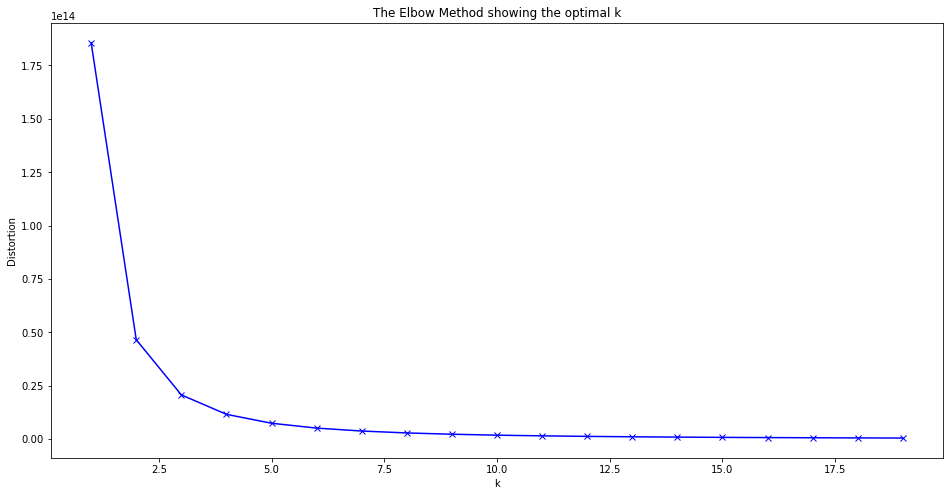

In [47]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [48]:
km = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(X_train_pp)

In [49]:
y_km

array([2, 0, 0, ..., 1, 2, 0])

In [50]:
all_train_pp_aux = pd.concat((X_train_pp, y_train), axis = 1)
all_train_pp_aux

,V4,V5,V6,V7,V1_1,V1_2,V1_3,V1_4,V1_5,V2_1,V2_2,V2_3,V2_4,Class
82677,1.594403,-0.197887,0.522237,146328.0,0,0,1,0,0,0,0,1,0,3
2843,0.549953,1.128656,-0.126258,79479.0,1,0,0,0,0,1,0,0,0,10
50670,0.344040,-0.116648,1.169737,101775.0,0,1,0,0,0,0,1,0,0,4
128441,-1.580786,0.324348,0.980933,137973.0,0,0,0,0,1,0,0,0,1,2
10592,0.712871,-0.242187,1.246126,119402.0,1,0,0,0,0,0,1,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102327,-0.539679,1.360420,0.693155,47575.0,0,0,0,1,0,0,1,0,0,3
97617,-0.638641,-0.567841,-0.013081,26584.0,0,0,0,1,0,0,1,0,0,11
21584,0.943929,-0.783505,0.499441,49255.0,1,0,0,0,0,1,0,0,0,3
36543,0.047070,-0.478605,-1.031014,114460.0,0,1,0,0,0,0,1,0,0,3


In [51]:
all_train_pp_aux = all_train_pp_aux.reset_index(drop = True)
all_train_pp_aux

,V4,V5,V6,V7,V1_1,V1_2,V1_3,V1_4,V1_5,V2_1,V2_2,V2_3,V2_4,Class
0,1.594403,-0.197887,0.522237,146328.0,0,0,1,0,0,0,0,1,0,3
1,0.549953,1.128656,-0.126258,79479.0,1,0,0,0,0,1,0,0,0,10
2,0.344040,-0.116648,1.169737,101775.0,0,1,0,0,0,0,1,0,0,4
3,-1.580786,0.324348,0.980933,137973.0,0,0,0,0,1,0,0,0,1,2
4,0.712871,-0.242187,1.246126,119402.0,1,0,0,0,0,0,1,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82425,-0.539679,1.360420,0.693155,47575.0,0,0,0,1,0,0,1,0,0,3
82426,-0.638641,-0.567841,-0.013081,26584.0,0,0,0,1,0,0,1,0,0,11
82427,0.943929,-0.783505,0.499441,49255.0,1,0,0,0,0,1,0,0,0,3
82428,0.047070,-0.478605,-1.031014,114460.0,0,1,0,0,0,0,1,0,0,3


In [52]:
all_train_pp_aux = pd.concat((all_train_pp_aux, pd.DataFrame(y_km, columns = ['cluster'])), axis = 1)

In [53]:
all_train_pp_aux

,V4,V5,V6,V7,V1_1,V1_2,V1_3,V1_4,V1_5,V2_1,V2_2,V2_3,V2_4,Class,cluster
0,1.594403,-0.197887,0.522237,146328.0,0,0,1,0,0,0,0,1,0,3,2
1,0.549953,1.128656,-0.126258,79479.0,1,0,0,0,0,1,0,0,0,10,0
2,0.344040,-0.116648,1.169737,101775.0,0,1,0,0,0,0,1,0,0,4,0
3,-1.580786,0.324348,0.980933,137973.0,0,0,0,0,1,0,0,0,1,2,2
4,0.712871,-0.242187,1.246126,119402.0,1,0,0,0,0,0,1,0,0,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82425,-0.539679,1.360420,0.693155,47575.0,0,0,0,1,0,0,1,0,0,3,1
82426,-0.638641,-0.567841,-0.013081,26584.0,0,0,0,1,0,0,1,0,0,11,1
82427,0.943929,-0.783505,0.499441,49255.0,1,0,0,0,0,1,0,0,0,3,1
82428,0.047070,-0.478605,-1.031014,114460.0,0,1,0,0,0,0,1,0,0,3,2


In [54]:
all_train_pp_aux.columns.values

array(['V4', 'V5', 'V6', 'V7', 'V1_1', 'V1_2', 'V1_3', 'V1_4', 'V1_5',
       'V2_1', 'V2_2', 'V2_3', 'V2_4', 'Class', 'cluster'], dtype=object)

In [55]:
all_train_pp_aux_0 = all_train_pp_aux[all_train_pp_aux['cluster'] == 0]
all_train_pp_aux_0

,V4,V5,V6,V7,V1_1,V1_2,V1_3,V1_4,V1_5,V2_1,V2_2,V2_3,V2_4,Class,cluster
1,0.549953,1.128656,-0.126258,79479.0,1,0,0,0,0,1,0,0,0,10,0
2,0.344040,-0.116648,1.169737,101775.0,0,1,0,0,0,0,1,0,0,4,0
6,-1.344493,1.555012,-0.866678,94399.0,0,0,0,0,1,0,0,1,0,4,0
15,0.426561,0.794688,-0.957143,102702.0,0,1,0,0,0,1,0,0,0,4,0
17,-1.145371,1.507073,-1.432201,75765.0,0,0,0,0,1,0,0,1,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82415,-1.193853,0.529032,1.130262,79620.0,0,0,0,0,1,0,0,1,0,4,0
82420,1.165863,-0.681998,1.714792,69887.0,0,0,1,0,0,0,1,0,0,5,0
82421,0.324382,1.397739,-1.559008,77681.0,0,1,0,0,0,0,1,0,0,9,0
82422,-0.887149,0.356061,-0.614671,103588.0,0,0,0,0,1,0,1,0,0,7,0


In [56]:
all_train_pp_aux_0.Class.value_counts()

4     13628
10     3184
7      3143
3      2417
9      2335
5      1011
6       698
2       505
1       448
8       130
11      107
Name: Class, dtype: int64

In [57]:
all_train_pp_aux_1 = all_train_pp_aux[all_train_pp_aux['cluster'] == 1]
all_train_pp_aux_1

,V4,V5,V6,V7,V1_1,V1_2,V1_3,V1_4,V1_5,V2_1,V2_2,V2_3,V2_4,Class,cluster
5,-0.599115,0.308228,-0.146027,29094.0,0,0,0,1,0,1,0,0,0,1,1
8,-0.155563,-1.560056,-1.377549,7609.0,0,0,0,1,0,0,1,0,0,6,1
10,-0.829017,-0.932887,0.334216,11939.0,0,0,0,0,1,1,0,0,0,4,1
11,-1.334906,1.532312,-0.206944,16880.0,0,0,0,0,1,0,0,1,0,4,1
12,-1.713955,0.236001,1.000808,31863.0,0,0,0,0,1,1,0,0,0,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82418,-0.482030,-0.917359,0.492583,23212.0,0,0,0,1,0,0,1,0,0,5,1
82423,1.068856,-1.506256,-0.180211,13251.0,0,0,1,0,0,0,1,0,0,3,1
82425,-0.539679,1.360420,0.693155,47575.0,0,0,0,1,0,0,1,0,0,3,1
82426,-0.638641,-0.567841,-0.013081,26584.0,0,0,0,1,0,0,1,0,0,11,1


In [58]:
all_train_pp_aux_1.Class.value_counts()

4     9309
3     5784
10    3481
7     3213
6     1676
9     1433
5     1040
2      478
1      436
8      315
11     289
Name: Class, dtype: int64

In [59]:
all_train_pp_aux_2 = all_train_pp_aux[all_train_pp_aux['cluster'] == 2]
all_train_pp_aux_2

,V4,V5,V6,V7,V1_1,V1_2,V1_3,V1_4,V1_5,V2_1,V2_2,V2_3,V2_4,Class,cluster
0,1.594403,-0.197887,0.522237,146328.0,0,0,1,0,0,0,0,1,0,3,2
3,-1.580786,0.324348,0.980933,137973.0,0,0,0,0,1,0,0,0,1,2,2
4,0.712871,-0.242187,1.246126,119402.0,1,0,0,0,0,0,1,0,0,4,2
7,0.804979,0.879016,-1.546203,118515.0,1,0,0,0,0,0,0,1,0,9,2
9,-1.173039,0.254111,1.414928,125170.0,0,0,0,0,1,0,0,1,0,7,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82412,-1.350338,-0.643346,0.474719,156678.0,0,0,0,0,1,0,0,0,1,3,2
82417,1.021299,1.079088,-1.602399,137321.0,1,0,0,0,0,0,1,0,0,7,2
82419,0.915841,0.007771,-0.322618,143780.0,1,0,0,0,0,0,0,1,0,7,2
82424,1.605651,-0.125977,1.636413,153290.0,0,0,1,0,0,0,0,0,1,7,2


In [60]:
all_train_pp_aux_2.Class.value_counts()

3     8158
7     7265
4     4231
10    2610
9     2116
5      994
1      613
8      407
2      377
11     308
6      291
Name: Class, dtype: int64

In [62]:
all_train_pp_pro = ohe(all_train_pp_aux, ['cluster'])
all_train_pp_pro

,V4,V5,V6,V7,V1_1,V1_2,V1_3,V1_4,V1_5,V2_1,V2_2,V2_3,V2_4,Class,cluster_0,cluster_1,cluster_2
0,1.594403,-0.197887,0.522237,146328.0,0,0,1,0,0,0,0,1,0,3,0,0,1
1,0.549953,1.128656,-0.126258,79479.0,1,0,0,0,0,1,0,0,0,10,1,0,0
2,0.344040,-0.116648,1.169737,101775.0,0,1,0,0,0,0,1,0,0,4,1,0,0
3,-1.580786,0.324348,0.980933,137973.0,0,0,0,0,1,0,0,0,1,2,0,0,1
4,0.712871,-0.242187,1.246126,119402.0,1,0,0,0,0,0,1,0,0,4,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82425,-0.539679,1.360420,0.693155,47575.0,0,0,0,1,0,0,1,0,0,3,0,1,0
82426,-0.638641,-0.567841,-0.013081,26584.0,0,0,0,1,0,0,1,0,0,11,0,1,0
82427,0.943929,-0.783505,0.499441,49255.0,1,0,0,0,0,1,0,0,0,3,0,1,0
82428,0.047070,-0.478605,-1.031014,114460.0,0,1,0,0,0,0,1,0,0,3,0,0,1


In [64]:
corr = pd.concat((all_train_pp_pro, y_train), axis = 1).corr()
corr.style.background_gradient(cmap = 'YlOrRd')

,V4,V5,V6,V7,V1_1,V1_2,V1_3,V1_4,V1_5,V2_1,V2_2,V2_3,V2_4,cluster_0,cluster_1,cluster_2
V4,1.000000,-0.090482,-0.022802,0.026448,0.348591,0.082450,0.681512,-0.234276,-0.764936,-0.030278,0.004961,-0.031910,0.061016,0.028597,-0.039142,0.010514
V5,-0.090482,1.000000,-0.366917,0.026174,0.012489,-0.027603,-0.049416,-0.047763,0.100362,0.055597,0.003832,0.004071,-0.067802,0.055530,-0.046703,-0.008910
V6,-0.022802,-0.366917,1.000000,0.013580,-0.052831,-0.027282,0.018800,0.026907,0.027725,0.050244,-0.016560,-0.021568,-0.013143,0.058276,-0.042297,-0.016072
V7,0.026448,0.026174,0.013580,1.000000,0.056914,0.023734,-0.007802,-0.051150,-0.016214,-0.264878,-0.284447,0.240240,0.329748,0.000394,-0.815690,0.815922
V1_1,0.348591,0.012489,-0.052831,0.056914,1.000000,-0.212044,-0.217959,-0.218642,-0.269003,-0.036018,-0.050092,0.023046,0.067200,0.010783,-0.063665,0.052907
V1_2,0.082450,-0.027603,-0.027282,0.023734,-0.212044,1.000000,-0.230749,-0.231471,-0.284788,0.023240,0.003547,-0.001791,-0.026694,0.041915,-0.042387,0.000414
V1_3,0.681512,-0.049416,0.018800,-0.007802,-0.217959,-0.230749,1.000000,-0.237929,-0.292732,-0.009343,0.025139,-0.044736,0.030849,0.001733,0.010964,-0.012709
V1_4,-0.234276,-0.047763,0.026907,-0.051150,-0.218642,-0.231471,-0.237929,1.000000,-0.293649,-0.016103,0.009315,0.015817,-0.009517,-0.030192,0.061480,-0.031271
V1_5,-0.764936,0.100362,0.027725,-0.016214,-0.269003,-0.284788,-0.292732,-0.293649,1.000000,0.032762,0.008459,0.007863,-0.052355,-0.020414,0.026214,-0.005777
V2_1,-0.030278,0.055597,0.050244,-0.264878,-0.036018,0.023240,-0.009343,-0.016103,0.032762,1.000000,-0.353920,-0.354568,-0.315194,0.065591,0.186037,-0.251912


### Modelado

In [65]:
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

### Checamos la distribución de la clase a predecir

In [66]:
y_train.value_counts()

4     27168
3     16359
7     13621
10     9275
9      5884
5      3045
6      2665
1      1497
2      1360
8       852
11      704
Name: Class, dtype: int64

In [67]:
y_test.value_counts()

4     27312
3     16351
7     13623
10     9086
9      5895
5      3123
6      2545
2      1488
1      1476
8       854
11      677
Name: Class, dtype: int64

### Balanceamos clases

In [ ]:
#!pip install imblearn

In [ ]:
from imblearn.over_sampling import SMOTE # Library to Balance Dataset
smote = SMOTE()
X_train_b, y_train_b = smote.fit_resample(X_train_pp, y_train) # Balancing our Data
X_train_b, y_train_b # Checking our new shape after Over_Sampling

In [ ]:
y_train_b.value_counts()

In [68]:
accuracy = {}

def train_model(model, model_name, x_tr, y_tr, x_ts, y_ts):
    print(model_name)
    
    # Fitting model
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, x_tr, y_tr, cv=kfold, scoring='accuracy')
    print(cv_results)
    msg = "%s: %f (%f)" % (model_name, cv_results.mean(), cv_results.std())
    print(msg)
    
    retrained_model = model.fit(x_tr, y_tr)
    
    # Predicting
    pred = retrained_model.predict(x_ts)
    y_test_aux = np.array(y_ts)
    values = np.array([[pred[i], y_test_aux[i]] for i in range(len(y_test_aux))])
    print(values)
    print(pd.DataFrame(values, columns = ['pred', 'real']))
    
    #Model accuracy
    acc = accuracy_score(y_ts, pred) * 100
    accuracy[model_name] = acc
    print('accuracy_score', acc, '\n')
    
    # Classification Report
    print('Classification Report')
    print(classification_report(y_ts, pred))

In [ ]:
model = linear_model.LogisticRegression(penalty = 'l2', class_weight='balanced', verbose = True)
model_name='Logistic Regression'
train_model(model, model_name, X_train_pp, y_train, X_test_pp, y_test)

In [ ]:
np.array(y_test)

https://www.aprendemachinelearning.com/regresion-logistica-con-python-paso-a-paso/

## Asignación 2 &#x1F921;

Evalue su modelo final en el conjunto de test (X_test y y_test). Su práctica será evaluada acorde a las técnicas aplicadas, la estimación de $E_{out}$, el valor de $E_{test}$, y contra las métricas obtenidas por sus compañeros.